In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential

In [2]:
#1 collect data
paths = ["images/t_train",
         "images/t_test"]

tree_species = ["eucalyptus","pinus_pinaster","pinus_pinea","quercus_rotundifolia","quercus_suber"]

all_img = {}
for dir in paths:
  for species in tree_species:
    key = os.path.join(dir, species)
    value = os.listdir(os.path.join(dir,species))
    all_img[key] = value 
    print(f"Content count of {key}: {len(value)}")
# print: just for checking if the images are split in a good amount (test:15%, validation split later on)

Content count of images/t_train\eucalyptus: 425
Content count of images/t_train\pinus_pinaster: 369
Content count of images/t_train\pinus_pinea: 539
Content count of images/t_train\quercus_rotundifolia: 626
Content count of images/t_train\quercus_suber: 360
Content count of images/t_test\eucalyptus: 74
Content count of images/t_test\pinus_pinaster: 64
Content count of images/t_test\pinus_pinea: 95
Content count of images/t_test\quercus_rotundifolia: 110
Content count of images/t_test\quercus_suber: 63


In [3]:
#calculating factor of data augmentation to even out sample size differences
max_count_t10 = 626*30 #amount in train with factor 30 on largest
print(f"quercus_suber: use i factor = {int(max_count_t10/360)}")
print(f"pinus_pinea: use i factor = {int(max_count_t10/539)}")
print(f"pinus_pinaster: use i factor = {int(max_count_t10/369)}")
print(f"eucalyptus: use i factor = {int(max_count_t10/425)}")
z_val = {"quercus_rotundifolia": 30,
         "quercus_suber": int(max_count_t10/360),
         "pinus_pinea": int(max_count_t10/539),
         "pinus_pinaster": int(max_count_t10/369),
         "eucalyptus": int(max_count_t10/425)}

quercus_suber: use i factor = 52
pinus_pinea: use i factor = 34
pinus_pinaster: use i factor = 50
eucalyptus: use i factor = 44


In [3]:
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import img_to_array, load_img, image_dataset_from_directory

In [46]:
%%time
#multipy input images by x with modifications, saved into new folder.
datagen = ImageDataGenerator(
        rotation_range=30,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        fill_mode='nearest')

for path,imglist in all_img.items():

  parent_dir = os.path.dirname(path)
  tree_dir = os.path.basename(path)
  save_to_dir = os.path.join(parent_dir+"_samesplsz",tree_dir)

  if parent_dir.endswith("t_test"):
    continue
#   if tree_dir not in ('pinus_pinaster'):#"quercus_rotundifolia", 'quercus_suber', 'eucalyptus', 'pinus_pinea'
#     continue
  print("Working on:", tree_dir, "\tmultiplying by", z_val[tree_dir])

  for img_name in imglist:
    img = load_img(os.path.join(path, img_name), target_size=(200,200), keep_aspect_ratio=True)  # this is a PIL image, cropped to a square and resized

    x = img_to_array(img)  # Numpy array with shape (3, 200, 200)
    x = x.reshape((1,) + x.shape)  # Numpy array with shape (1, 3, 200, 200)

    i = 0
    for batch in datagen.flow(x, batch_size=1,
                              save_to_dir=save_to_dir, save_prefix=tree_dir, save_format='jpeg'):
        i += 1
        if i > z_val[tree_dir]:
            break 

Working on: eucalyptus 	multiplying by 44
Working on: pinus_pinaster 	multiplying by 50
Working on: pinus_pinea 	multiplying by 34
Working on: quercus_rotundifolia 	multiplying by 30
Working on: quercus_suber 	multiplying by 52
Wall time: 24min 25s


In [4]:
counts = {}
for path,imglist in all_img.items():
  parent_dir = os.path.dirname(path)
  if parent_dir.endswith("test"):
    continue
  tree_dir = os.path.basename(path)
  calc_img_fld = os.path.join(parent_dir+"_samesplsz",tree_dir)
  print(f"Content count of {calc_img_fld}: {len(os.listdir(calc_img_fld))}")
  counts[calc_img_fld] = len(os.listdir(calc_img_fld))

Content count of images/t_train_samesplsz\eucalyptus: 8520
Content count of images/t_train_samesplsz\pinus_pinaster: 8532
Content count of images/t_train_samesplsz\pinus_pinea: 8472
Content count of images/t_train_samesplsz\quercus_rotundifolia: 8594
Content count of images/t_train_samesplsz\quercus_suber: 8514


In [6]:
 ## DO NOT RUN BY CHANCE!! ##
  ###not happy with the data? delete it... and then comment out again!
# for path,imglist in all_img.items():
#   parent_dir = os.path.dirname(path)
#   if parent_dir.endswith("test"):
#     continue
#   tree_dir = os.path.basename(path)
#   calc_img_fld = os.path.join(parent_dir+"_samesplsz",tree_dir)           ##check: is it the right DIR???
#   for img_name in os.listdir(calc_img_fld):
#     os.remove(os.path.join(calc_img_fld, img_name))
#   print(f"Deleted content of {calc_img_fld}.")

In [5]:
countsum_valid = 0
countsum_train = 0
for k,v in counts.items():
  if "train"in k:
    countsum_train += v
print(f"Train total sum: {countsum_train}")

Validation total sum: 0, Train total sum: 42632


In [ ]:
###start on the model run

In [29]:
from keras import backend as K

img_width, img_height = 150, 150

epochs = 15
batch_size = 32

if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

In [30]:
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten
from keras.layers import Dense

model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=input_shape)) #32 filters, filtersize 3x3 
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

In [31]:
model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))
# model.add(Dropout(0.2)) #Tried different values, at the moment no dropout yielded best results
model.add(Dense(len(tree_species))) 
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam', 
              metrics=['accuracy']
              )

In [26]:
(train_dataset, valid_dataset) = tf.keras.utils.image_dataset_from_directory(
    'images/t_train_samesplsz',
    labels='inferred',
    label_mode='categorical',
    color_mode='rgb',
    batch_size=batch_size,
    image_size=(150, 150),
    validation_split=0.2, #splitting train and validation 80/20
    subset="both",
    seed=1
)

def normalize_pixels(image,label):
    image = tf.cast(image/255. ,tf.float32)
    return image,label

train_dataset = train_dataset.map(normalize_pixels)
valid_dataset = valid_dataset.map(normalize_pixels)

Found 42632 files belonging to 5 classes.
Using 34106 files for training.
Using 8526 files for validation.


In [27]:
nb_train_samples = 34106
nb_validation_samples = 8526

In [15]:
#just visually checking individual content in the train, 9 items
# plt.figure(figsize=(10, 10))
# for images, labels in train_dataset.take(1):
#   for i in range(9):
#     image = tf.cast(images[i]*255. ,tf.float32)
#     ax = plt.subplot(3, 3, i + 1)
#     plt.imshow(image.numpy().astype("uint8"))
#     plt.title(labels[i].numpy())
#     plt.axis("off")

In [ ]:
history = model.fit(
    train_dataset,
    steps_per_epoch=nb_train_samples // (batch_size*epochs), #has to be, otherwise it complains about not enough data
    epochs=epochs,
    validation_data=valid_dataset,
    validation_steps=nb_validation_samples // batch_size)

#model.save_weights('first_try.h5') 

In [ ]:
#model.summary()

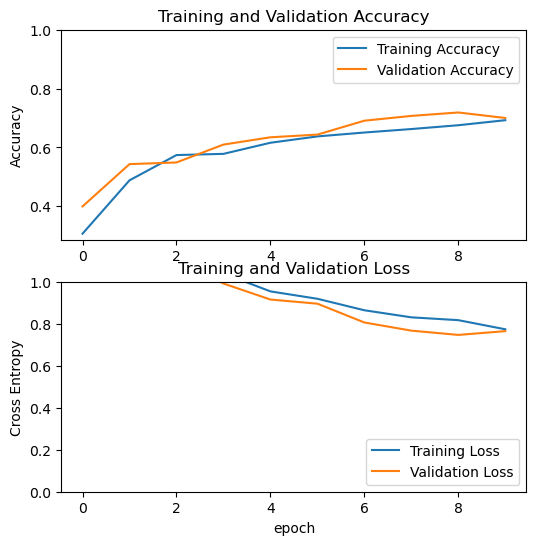

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(6, 6))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='upper right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='lower right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [21]:
test_dataset = tf.keras.utils.image_dataset_from_directory(
    'images/t_test',
    labels='inferred',
    label_mode='categorical',
    color_mode='rgb',
    batch_size=batch_size,
    image_size=(150, 150)
)

test_dataset = test_dataset.map(normalize_pixels)

Found 406 files belonging to 5 classes.


In [22]:
#Model accuracy on test data
model.evaluate(test_dataset)

13/13 [==============================] - 4s 231ms/step - loss: 1.3132 - accuracy: 0.5640


[1.3131777048110962, 0.564039409160614]

In [16]:
# Save the entire model
model.save('keras_model/model5')

INFO:tensorflow:Assets written to: keras_model/model5\assets


INFO:tensorflow:Assets written to: keras_model/model5\assets
